In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

# **Задание**
Используйте модель BERT для классификации настроения отзывов.

датасет - Набор данных содержит более 6,4 миллиона общедоступных отзывов на английском языке из раздела Steam Reviews магазина Steam, управляемого Valve. Каждый отзыв описывается текстом обзора, идентификатором игры, к которой он принадлежит, настроением отзыва (положительным или отрицательным) и количеством пользователей, которые сочли отзыв полезным.

In [2]:
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
!pip install transformers
!pip install tokenizers
from tokenizers import BertWordPieceTokenizer
import random as rn
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.2 MB/s eta 0:00:00


In [3]:
import random as rn

In [4]:
df_reviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Датасет с отзывами/dataset.csv', skiprows=lambda i: i>0 and rn.random() > 0.02)
df_reviews.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"No r8 revolver, 10/10 will play again.",1,1
1,10,Counter-Strike,This game appears to remain No. 1 FPS Action g...,1,0
2,10,Counter-Strike,10/10 Still the best game ever.,1,1
3,10,Counter-Strike,Best Game Ever xD But I Cant Play It On My MAC :/,1,0
4,10,Counter-Strike,Still the best of counter-strike! :) keep it a...,1,1


In [5]:
# преобразовать текст отзыва в строку
df_reviews = df_reviews[df_reviews.review_text.str.strip() != 'Early Access Review']
df_reviews["review_text"] = df_reviews["review_text"].astype(str)

# заменить -1 на 0
df_reviews_2 = df_reviews[df_reviews["review_score"].notnull()]
df_reviews_2["review_score"] = np.where(df_reviews_2["review_score"]==-1, 0, df_reviews_2["review_score"])

In [6]:
df_reviews_2

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"No r8 revolver, 10/10 will play again.",1,1
1,10,Counter-Strike,This game appears to remain No. 1 FPS Action g...,1,0
2,10,Counter-Strike,10/10 Still the best game ever.,1,1
3,10,Counter-Strike,Best Game Ever xD But I Cant Play It On My MAC :/,1,0
4,10,Counter-Strike,Still the best of counter-strike! :) keep it a...,1,1
...,...,...,...,...,...
128405,99910,Puzzle Pirates,Timeless classical mmorpg. I have been playing...,1,0
128406,99910,Puzzle Pirates,very nice game ever,1,0
128407,99910,Puzzle Pirates,Fun for about 10 mins or so but some might enj...,0,0
128408,99910,Puzzle Pirates,The game is very awefull and strange. I think ...,0,0


In [7]:
df_reviews_2.shape

(107987, 5)

In [8]:
df_reviews_2["review_score"].value_counts()

1    89349
0    18638
Name: review_score, dtype: int64

In [9]:
reviews = df_reviews_2["review_text"].values.tolist()
labels = df_reviews_2["review_score"].tolist()

разделим имеющийся датасет сначала на обучающую выборку и выборку для разделения на валидационную и тестовую (X_toval)

In [10]:
X_train, X_toval, y_train, y_toval = train_test_split(reviews, labels, test_size=.2)

X_validation, X_test, y_validation, y_test = train_test_split(X_toval, y_toval, test_size=.2)

In [11]:
len(X_train),len(X_validation), len(X_test)

(86389, 17278, 4320)

### Input Tokenization

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [13]:
import re
def text_preprocessing(text):
    clean_text = text.lower()
    clean_text = clean_text.replace('•', ' ')
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    clean_text = re.sub(r'\d+', '', clean_text)


    return clean_text

In [14]:
import torch
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # предобработка
            add_special_tokens=True,        # Добавит маркеры `[CLAMS]` и `[SEP]` в начало и конец
            max_length=MAX_LEN,                  # Сократит предложение до максимальной длины
            pad_to_max_length=True,
            return_attention_mask=True      # Создаст маску внимания
            )

        # результаты добавим в созданные списки
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # преобразование в тензоры
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [15]:
MAX_LEN = 64

train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_validation)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [16]:
train_inputs

tensor([[  101,  1353, 12665,  ...,  1122,  1336,   102],
        [  101,  1103,  5102,  ...,     0,     0,     0],
        [  101,  1142,  1110,  ...,  1618,  1190,   102],
        ...,
        [  101,  1142,  1342,  ...,     0,     0,     0],
        [  101,  3873,   170,  ..., 11273,  1895,   102],
        [  101,  1436,   175,  ...,     0,     0,     0]])

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels = torch.tensor(y_train)

val_labels = torch.tensor(y_validation)

batch_size = 16

# Create the DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Создание модели классификатора, который использует предварительно обученную модель BERT как основу для извлечения признаков.

In [18]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel


class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        # Если параметр freeze_bert установлен в True, параметры модели BERT замораживаются, то есть они не будут обновляться во время обучения классификатора.
        super(BertClassifier, self).__init__()

        D_in, H, D_out = 768, 50, 2

        # BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # экземпляр одноуровневого классификатора с прямой передачей
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    # Метод, который определяет, как данные проходят через модель.
    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 50.9 ms, sys: 0 ns, total: 50.9 ms
Wall time: 54.8 ms


функция инициализации классификатора Bert, оптимизатора и графика скорости обучения.

In [19]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):

    #Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # модель на графическом процессоре
    bert_classifier.to(device)

    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

Функция обучения

In [20]:
import random
import time
# функция потерь
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """начальное значение для воспроизводимости."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # время прошедшей эпохи
        t0_epoch, t0_batch = time.time(), time.time()

        # в начале эпохи сброс переменных отслеживания
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # обучение
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Входные данные и метки переносятся на GPU.
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Сбрасываются ранее рассчитанные градиенты.
            model.zero_grad()

            # Модель выполняет передачу вперед (forward) и вычисляет логиты.
            logits = model(b_input_ids, b_attn_mask)

            # Вычисляется функция потерь (кросс-энтропия) и градиенты распространяются назад (backward).
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()


            # Градиенты ограничиваются для предотвращения взрывающихся градиентов.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Обновляются параметры модели и выполняется шаг оптимизации.
            optimizer.step()
            scheduler.step()

            # Периодически выводится информация о процессе обучения.
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):

                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # После завершения каждого периода обучения измерение производительности модели
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):

    # Модель переводится в режим оценки (eval).
    model.eval()

    val_accuracy = []
    val_loss = []


    for batch in val_dataloader:

        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Модель применяется для предсказания логитов (без вычисления градиентов).
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Вычисляется потеря и добавляется в список val_loss.
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Предсказания сравниваются с метками, чтобы вычислить точность.
        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Средняя потеря и точность вычисляются по всем батчам.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [21]:
device = torch.device("cuda")
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.513981   |     -      |     -     |   4.51   
   1    |   40    |   0.453521   |     -      |     -     |   3.36   
   1    |   60    |   0.476139   |     -      |     -     |   3.37   
   1    |   80    |   0.489122   |     -      |     -     |   3.39   
   1    |   100   |   0.470411   |     -      |     -     |   3.39   
   1    |   120   |   0.492755   |     -      |     -     |   3.40   
   1    |   140   |   0.463937   |     -      |     -     |   3.41   
   1    |   160   |   0.488590   |     -      |     -     |   3.40   
   1    |   180   |   0.490478   |     -      |     -     |   3.43   
   1    |   200   |   0.413492   |     -      |     -     |   3.42   
   1    |   220   |   0.458834   |     -      |     -     |   3.44   
   1    |   240   |   0.482864   |     -      |     -     |   3.45   


In [22]:
torch.save(bert_classifier.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Иннополис/bert_classifier/bert_classifier.pt')

In [23]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):

    model.eval()

    all_logits = []


    for batch in test_dataloader:

        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)


    all_logits = torch.cat(all_logits, dim=0)

    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [24]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Вычисление предсказанных вероятностей на тестовом наборе и оценка классификатора

AUC: 0.6539
Accuracy: 82.88%


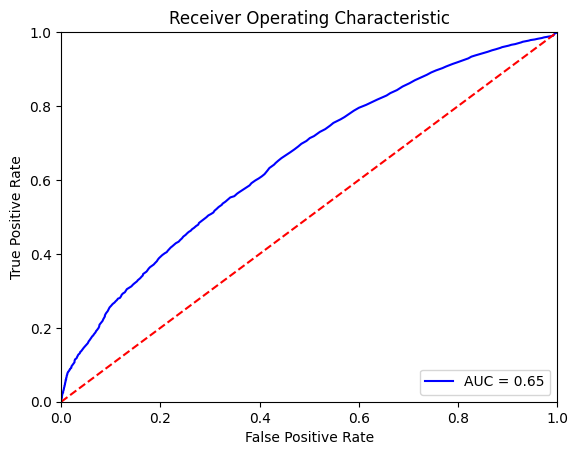

In [25]:
probs = bert_predict(bert_classifier, val_dataloader)

evaluate_roc(probs, y_validation)

Модель демонстрирует хороший score

## Демонстрация результата на примерах

In [26]:
X_test[1]

"Rogue like and exploration work great !  I took a guess on this game and I don't regret it. To complete a game it took about 2h. Its a mix between FTL and expedition conquistador.  Pro - The art The gameplay The possibility for some DLC The great feeling when you win The possibility The gestion  Against -  The only thing I can say agains this game its that I'm unable to finish/research everything. It bug me because I'm an achiever, but I do enjoy it and I will try to unlock all the achievement.  I will get my 20$ value"

Сначала подготовим тестовые данные в нужном виде

In [27]:
test_inputs, test_masks = preprocessing_for_bert(X_test)


test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

In [44]:
probs = bert_predict(bert_classifier, test_dataloader)

# Вычисление предсказанных вероятностей на тестовом наборе
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Прогнозируемое количество твитов неотрицательное
print("Number of tweets predicted non-negative: ", preds.sum())

Number of tweets predicted non-negative:  4320


In [45]:
preds

array([1, 1, 1, ..., 1, 1, 1])

In [38]:
X_test = pd.Series(X_test)

In [39]:
preds = pd.Series(preds)

In [40]:
output = X_test[preds==1]
list(output.sample(2))

["Although this game is 'story rich', I dont think the story is very good. Its full of cliches (writer with writer's block, boy wants to play, dad wants to work, mom tries to hold family together, etc) and extremely superficial. You make choices but they dont mean anything when the consequence is just text at the end of the scene. Its just so...predictable. All the kid ever wants to do is play, so, shocker, when you dont play with him he gets depressed. So what? Why am I suppose to care about the kid at all? The game doesnt give you any reason to like any of the characters.  And we are suppose to believe that Dan is so busy he cant do anything else with his wife and kids but. . . hes not. He sits around the house all day, goes camping, fishing. In one chapter they show a schedule. It has 8 hours sleep, 1 hour break, 2 hours decompression. Really? Thats 11 hours where hes doing nothing. Real busy people rest half that amount on any given workday.  I really hate to hammer an indie game. 

In [42]:
output = X_test[preds==0]
list(output.sample(2))

In [43]:
output

Series([], dtype: object)